In [1]:
import numpy as np
import xarray as xr
import cmocean.cm as cmo
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy
from glob import glob
from matplotlib import pyplot as plt
import matplotlib.colors as colors
import matplotlib.path as mpath
plt.rcParams['figure.facecolor'] = 'white'
%config InlineBackend.print_figure_kwargs = {'bbox_inches': None}

In [60]:
def prepro(ds):
    return ds.isel(y=slice(800, None))

In [3]:
grid_files = ["/data0/project/drakkar/CONFIGS/CREG12.L75/GRID/CREG12.L75-REF08_mask.nc", 
              "/data0/project/drakkar/CONFIGS/CREG12.L75/GRID/CREG12.L75-REF08_mesh_hgr.nc",
              "/data0/project/drakkar/CONFIGS/CREG12.L75/GRID/CREG12.L75-REF08_mesh_zgr.nc"]

In [24]:
grid = xr.open_mfdataset(grid_files, parallel=True, preprocess=prepro)

In [56]:
u_data_filesREF = sorted(glob("/data0/project/drakkar/USERS/jrieck/CREG12.L75-REF08-UV_clim/" 
                                + "/CREG12.L75-REF08_*.5d_U2Dclim.nc"))
v_data_filesREF = sorted(glob("/data0/project/drakkar/USERS/jrieck/CREG12.L75-REF08-UV_clim/" 
                                + "/CREG12.L75-REF08_*.5d_V2Dclim.nc"))
u_data_filesFUT = sorted(glob("/data0/project/drakkar/USERS/jrieck/CREG12.L75-FUT08-UV_clim" 
                                + "/CREG12.L75-FUT08_*.5d_U2Dclim.nc"))
v_data_filesFUT = sorted(glob("/data0/project/drakkar/USERS/jrieck/CREG12.L75-FUT08-UV_clim" 
                                + "/CREG12.L75-FUT08_*.5d_V2Dclim.nc"))
psi_data_files = sorted(glob("/data0/project/drakkar/USERS/jrieck/stream_function.nc"))

In [61]:
uREF = xr.open_mfdataset(u_data_filesREF, parallel=True, preprocess=prepro)
vREF = xr.open_mfdataset(v_data_filesREF, parallel=True, preprocess=prepro)
uFUT = xr.open_mfdataset(u_data_filesFUT, parallel=True, preprocess=prepro)
vFUT = xr.open_mfdataset(v_data_filesFUT, parallel=True, preprocess=prepro)
psi = xr.open_mfdataset(psi_data_files, parallel=True).isel(y=slice(300, None))

In [603]:
psiREFplot = psi.Streamfunction_REF.where(psi.Streamfunction_REF!=0).compute()
psiREFplot[632:634, 806] = np.nan
psiREFplot[805:807, 766:768] = np.nan
psiFUTplot = psi.Streamfunction_FUT.where(psi.Streamfunction_FUT!=0).compute()
psiFUTplot[554:558, 760:830] = np.nan
psiFUTplot[654:656, 760:830] = np.nan
psiFUTplot[741:743, 760:830] = np.nan
psiFUTplot[791, 760:830] = np.nan
psiFUTplot[811, 760:830] = np.nan
psiDIFFplot = (psiFUTplot - psiREFplot).compute()
psiDIFFplot[746, 760:830] = np.nan
psiDIFFplot[797, 760:830] = np.nan
psiDIFFplot[818, 760:830] = np.nan

In [76]:
utau_REF = uREF.sozotaux.interp(x=np.arange(0.5, len(uREF.x), 1)).compute()
vtau_REF = vREF.sometauy.interp(y=np.arange(0.5, len(vFUT.y), 1)).compute()
utau_FUT = uFUT.sozotaux.interp(x=np.arange(0.5, len(uREF.x), 1)).compute()
vtau_FUT = vFUT.sometauy.interp(y=np.arange(0.5, len(vFUT.y), 1)).compute()

In [82]:
tau_REF = (((utau_REF**2) + (vtau_REF**2))**0.5).mean("time_counter").compute()
tau_FUT = (((utau_FUT**2) + (vtau_FUT**2))**0.5).mean("time_counter").compute()

In [83]:
utau_REFplot = utau_REF.mean("time_counter").compute()
vtau_REFplot = vtau_REF.mean("time_counter").compute()
utau_FUTplot = utau_FUT.mean("time_counter").compute()
vtau_FUTplot = vtau_FUT.mean("time_counter").compute()

In [361]:
for ds in [psiREFplot, psiFUTplot, tau_REF, tau_FUT, 
           utau_REFplot, vtau_REFplot, utau_FUTplot, vtau_FUTplot]:
    ds = ds.assign_coords({"nav_lon": grid.nav_lon, "nav_lat": grid.nav_lat})

In [362]:
def map_config(ax):
    ax.set_extent([-180, 180, 67, 90], ccrs.PlateCarree())
    ax.add_feature(cfeature.LAND, facecolor="silver")
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    ax.set_boundary(circle, transform=ax.transAxes)
    ax.invert_yaxis()
    ax.invert_xaxis()

In [604]:
proj = ccrs.NearsidePerspective(central_longitude=170, central_latitude=75, satellite_height=35785831)

In [605]:
qs = 30
x = tau_REF.nav_lon.values[0::qs, 0::qs]
y = tau_REF.nav_lat.values[0::qs, 0::qs]

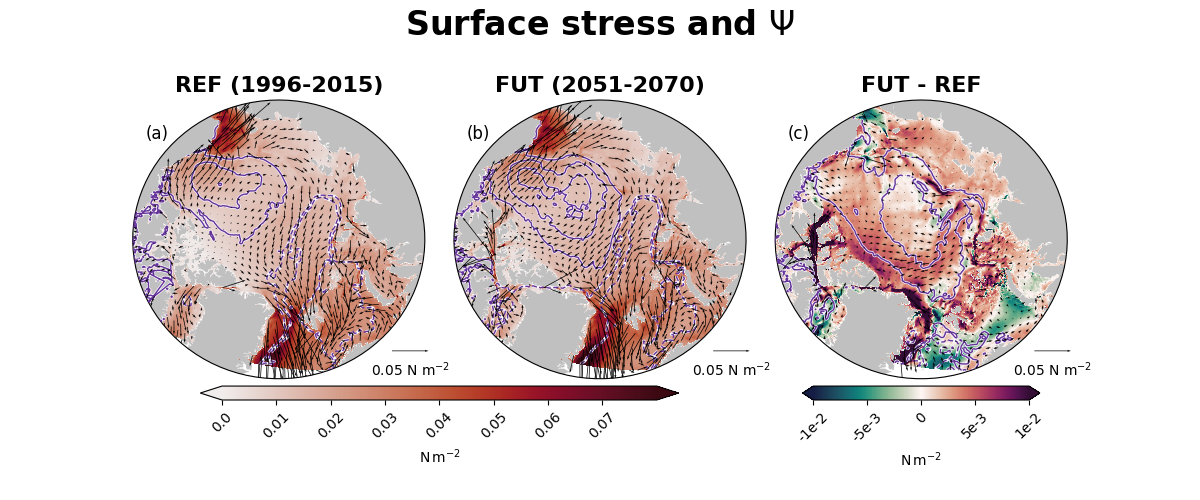

In [606]:
fig = plt.figure(figsize=(12, 5))
gs = fig.add_gridspec(2, 24, height_ratios=[1, 0.05])

ax1 = fig.add_subplot(gs[0, 0:8], projection=proj)
ax2 = fig.add_subplot(gs[0, 8:16], projection=proj)
ax3 = fig.add_subplot(gs[0, 16:24], projection=proj)
axcb1 = fig.add_subplot(gs[1, 2:14])
axcb2 = fig.add_subplot(gs[1, 17:23])

t1 = tau_REF.plot(x='nav_lon', y='nav_lat', cmap=cmo.amp, 
                  vmin=0, vmax=0.08,
                  ax=ax1, transform=ccrs.PlateCarree(), rasterized=True, 
                  zorder=1, add_colorbar=False)
t2 = tau_FUT.plot(x='nav_lon', y='nav_lat', cmap=cmo.amp, 
                  vmin=0, vmax=0.08,
                  ax=ax2, transform=ccrs.PlateCarree(), rasterized=True, 
                  zorder=1, add_colorbar=False)
t3 = (tau_FUT - tau_REF).plot(x='nav_lon', y='nav_lat', cmap=cmo.curl, 
                              vmin=-0.01, vmax=0.01,
                              ax=ax3, transform=ccrs.PlateCarree(), rasterized=True, 
                              zorder=1, add_colorbar=False)

p1 = psiREFplot.plot.contour(x='nav_lon', y='nav_lat', levels=[-4, -2, 0, 2, 4], 
                             colors="ghostwhite", linewidths=2,
                             ax=ax1, transform=ccrs.PlateCarree(), zorder=2)
p1 = psiREFplot.plot.contour(x='nav_lon', y='nav_lat', levels=[-4, -2, 0, 2, 4], 
                             colors="rebeccapurple", linewidths=1,
                             ax=ax1, transform=ccrs.PlateCarree(), zorder=3)
p2 = psiFUTplot.plot.contour(x='nav_lon', y='nav_lat', levels=[-4, -2, 0, 2, 4], 
                             colors="ghostwhite", linewidths=2,
                             ax=ax2, transform=ccrs.PlateCarree(), zorder=2)
p2 = psiFUTplot.plot.contour(x='nav_lon', y='nav_lat', levels=[-4, -2, 0, 2, 4], 
                             colors="rebeccapurple", linewidths=1,
                             ax=ax2, transform=ccrs.PlateCarree(), zorder=3)
p3 = psiDIFFplot.plot.contour(x='nav_lon', y='nav_lat', levels=[-4, -2, 0, 2, 4], 
                              colors="ghostwhite", linewidths=2,
                              ax=ax3, transform=ccrs.PlateCarree(), zorder=2)
p3 = psiDIFFplot.plot.contour(x='nav_lon', y='nav_lat', levels=[-4, -2, 0, 2, 4], 
                              colors="rebeccapurple", linewidths=1,
                              ax=ax3, transform=ccrs.PlateCarree(), zorder=3)

q1 = ax1.quiver(x, y,
                utau_REFplot.values[0::qs, 0::qs], vtau_REFplot.values[0::qs, 0::qs],
                scale=0.4, transform=ccrs.PlateCarree(), rasterized=True, zorder=4)
q1.set_UVC(utau_REFplot.values[0::qs, 0::qs], vtau_REFplot.values[0::qs, 0::qs])
q1k = ax1.quiverkey(q1, 0.95, 0.1, 0.05, r'0.05 N m$^{-2}$', labelpos='S',
                      coordinates='axes')
q2 = ax2.quiver(x, y,
                utau_FUTplot.values[0::qs, 0::qs], vtau_FUTplot.values[0::qs, 0::qs],
                scale=0.4, transform=ccrs.PlateCarree(), rasterized=True, zorder=4)
q2.set_UVC(utau_FUTplot.values[0::qs, 0::qs], vtau_FUTplot.values[0::qs, 0::qs])
q2k = ax2.quiverkey(q2, 0.95, 0.1, 0.05, r'0.05 N m$^{-2}$', labelpos='S',
                      coordinates='axes')
q3 = ax3.quiver(x, y,
                (utau_REFplot.values[0::qs, 0::qs] - utau_FUTplot.values[0::qs, 0::qs]), 
                (vtau_REFplot.values[0::qs, 0::qs] - utau_FUTplot.values[0::qs, 0::qs]),
                scale=0.4, transform=ccrs.PlateCarree(), rasterized=True, zorder=4)
q3.set_UVC((utau_FUTplot.values[0::qs, 0::qs] - utau_REFplot.values[0::qs, 0::qs]),
           (vtau_FUTplot.values[0::qs, 0::qs] - vtau_REFplot.values[0::qs, 0::qs]))
q3k = ax3.quiverkey(q3, 0.95, 0.1, 0.05, r'0.05 N m$^{-2}$', labelpos='S',
                      coordinates='axes')

[map_config(ax) for ax in [ax1, ax2, ax3]];

fig.text(0.5, 0.93, r"Surface stress and $\Psi$", fontsize=24, fontweight="bold", ha="center")

ax1.set_title("REF (1996-2015)", fontsize=16, fontweight="bold")
ax2.set_title("FUT (2051-2070)", fontsize=16, fontweight="bold")
ax3.set_title("FUT - REF", fontsize=16, fontweight="bold")

[ax.text(-140, 64, t, fontsize=12, transform=ccrs.PlateCarree()) 
 for ax, t in zip([ax1, ax2, ax3], ["(a)", "(b)", "(c)"])]

cb1 = plt.colorbar(t1, cax=axcb1, orientation="horizontal", extend="both")
axcb1.set_xticks(np.arange(0, 0.08, 0.01))
axcb1.set_xticklabels(np.arange(0, 0.08, 0.01), rotation=45, ha='center')
axcb1.set_xlabel(r"N$\,$m$^{-2}$")
cb2 = plt.colorbar(t3, cax=axcb2, orientation="horizontal", extend="both")
axcb2.set_xticks([-1e-2, -5e-3, 0, 5e-3, 1e-2])
axcb2.set_xticklabels(["-1e-2", "-5e-3", "0", "5e-3", "1e-2"], rotation=45, ha='center')
axcb2.set_xlabel(r"N$\,$m$^{-2}$")

plt.subplots_adjust(wspace=0.1, hspace=0.05, bottom=0.2, top=0.8, left=0.1, right=0.9)

plt.savefig("figures/surface_stress_and_psi_proj.png", dpi=300)

In [598]:
qs = 40
x = tau_REF.x.values[0::qs]
y = tau_REF.y.values[0::qs]

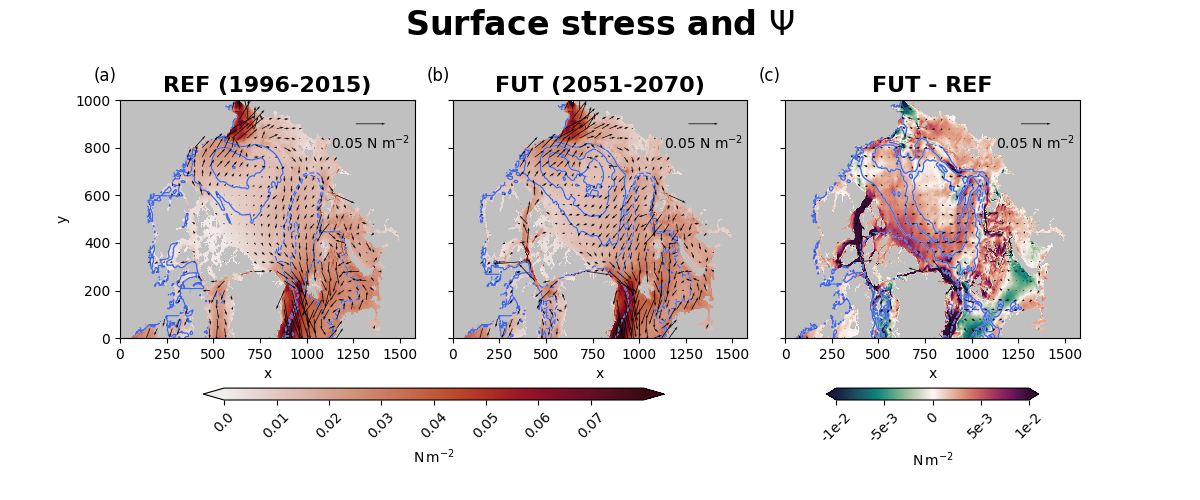

In [599]:
fig = plt.figure(figsize=(12, 5))
gs = fig.add_gridspec(2, 24, height_ratios=[1, 0.05])

ax1 = fig.add_subplot(gs[0, 0:8])
ax2 = fig.add_subplot(gs[0, 8:16])
ax3 = fig.add_subplot(gs[0, 16:24])
axcb1 = fig.add_subplot(gs[1, 2:14])
axcb2 = fig.add_subplot(gs[1, 17:23])

t1 = tau_REF.plot(x='x', y='y', cmap=cmo.amp, 
                  vmin=0, vmax=0.08,
                  ax=ax1,
                  zorder=1, add_colorbar=False)
t2 = tau_FUT.plot(x='x', y='y', cmap=cmo.amp, 
                  vmin=0, vmax=0.08,
                  ax=ax2, 
                  zorder=1, add_colorbar=False)
t3 = (tau_FUT - tau_REF).plot(x='x', y='y', cmap=cmo.curl, 
                              vmin=-0.01, vmax=0.01,
                              ax=ax3, 
                              zorder=1, add_colorbar=False)

p1 = psiREFplot.plot.contour(x='x', y='y', levels=[-4, -2, 0, 2, 4], 
                             colors="snow", linewidths=1,
                             ax=ax1, zorder=2)
p1 = psiREFplot.plot.contour(x='x', y='y', levels=[-4, -2, 0, 2, 4], 
                             colors="royalblue", linewidths=1,
                             ax=ax1, zorder=3)
p2 = psiFUTplot.plot.contour(x='x', y='y', levels=[-4, -2, 0, 2, 4], 
                             colors="snow", linewidths=1,
                             ax=ax2, zorder=2)
p2 = psiFUTplot.plot.contour(x='x', y='y', levels=[-4, -2, 0, 2, 4], 
                             colors="royalblue", linewidths=1,
                             ax=ax2, zorder=3)
p3 = (psiFUTplot - psiREFplot).plot.contour(x='x', y='y', levels=[-2, -1, 0, 1, 2], 
                                            colors="snow", linewidths=1,
                                            ax=ax3, zorder=2)
p3 = (psiFUTplot - psiREFplot).plot.contour(x='x', y='y', levels=[-2, -1, 0, 1, 2], 
                                            colors="royalblue", linewidths=1,
                                            ax=ax3, zorder=3)

q1 = ax1.quiver(x, y,
                utau_REFplot.values[0::qs, 0::qs], vtau_REFplot.values[0::qs, 0::qs],
                scale=0.5, color="black", zorder=4)
q1k = ax1.quiverkey(q1, 0.85, 0.9, 0.05, r'0.05 N m$^{-2}$', labelpos='S',
                      coordinates='axes')
q2 = ax2.quiver(x, y,
                utau_FUTplot.values[0::qs, 0::qs], vtau_FUTplot.values[0::qs, 0::qs],
                scale=0.5, color="black", zorder=4)
q2k = ax2.quiverkey(q2, 0.85, 0.9, 0.05, r'0.05 N m$^{-2}$', labelpos='S',
                      coordinates='axes')
q3 = ax3.quiver(x, y,
                (utau_REFplot.values[0::qs, 0::qs] - utau_FUTplot.values[0::qs, 0::qs]), 
                (vtau_REFplot.values[0::qs, 0::qs] - vtau_FUTplot.values[0::qs, 0::qs]),
                scale=0.5, color="black", zorder=4)
q3k = ax3.quiverkey(q3, 0.85, 0.9, 0.05, r'0.05 N m$^{-2}$', labelpos='S',
                      coordinates='axes')


fig.text(0.5, 0.93, r"Surface stress and $\Psi$", fontsize=24, fontweight="bold", ha="center")

ax1.set_title("REF (1996-2015)", fontsize=16, fontweight="bold")
ax2.set_title("FUT (2051-2070)", fontsize=16, fontweight="bold")
ax3.set_title("FUT - REF", fontsize=16, fontweight="bold")

[ax.text(-140, 1080, t, fontsize=12) 
 for ax, t in zip([ax1, ax2, ax3], ["(a)", "(b)", "(c)"])]
[ax.set_ylabel("") for ax in [ax2, ax3]]
[ax.set_yticklabels([]) for ax in [ax2, ax3]]
[ax.set_facecolor("silver") for ax in [ax1, ax2, ax3]]

cb1 = plt.colorbar(t1, cax=axcb1, orientation="horizontal", extend="both")
axcb1.set_xticks(np.arange(0, 0.08, 0.01))
axcb1.set_xticklabels(np.arange(0, 0.08, 0.01), rotation=45, ha='center')
axcb1.set_xlabel(r"N$\,$m$^{-2}$")
cb2 = plt.colorbar(t3, cax=axcb2, orientation="horizontal", extend="both")
axcb2.set_xticks([-1e-2, -5e-3, 0, 5e-3, 1e-2])
axcb2.set_xticklabels(["-1e-2", "-5e-3", "0", "5e-3", "1e-2"], rotation=45, ha='center')
axcb2.set_xlabel(r"N$\,$m$^{-2}$")

plt.subplots_adjust(wspace=10, hspace=0.4, bottom=0.2, top=0.8, left=0.1, right=0.9)

plt.savefig("figures/surface_stress_and_psi.png", dpi=300)